In [49]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score,classification_report,pairwise_distances_argmin_min,silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from preprocess_data import preprocess_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances,pairwise_distances
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import entropy
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import defaultdict


In [5]:
# Load the data
data = preprocess_data()

data['num_genres'] = data['genre'].apply(len)
data = data[data['num_genres'] == 1]

descriptions = data['description_processed'].tolist()
genres = data['genre'].tolist()

In [6]:
# Encode the genres as numerical labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(genres)

# Load a pre-trained sentence-transformer model to convert text to embeddings
#model = SentenceTransformer('bert-base-nli-mean-tokens')
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
# Convert descriptions to vector embeddings
X = model.encode(descriptions, show_progress_bar=True)

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Batches: 100%|██████████| 762/762 [01:05<00:00, 11.59it/s]


In [94]:
def active_learning_with_faiss(X, y, dynamic_clusters, initial_train_size=250, iterations=20, uncertainty_threshold=0.2, budget_per_iteration=500, num_clusters=10):
    # Normalize the embeddings for cosine similarity
    X_normalized = normalize(X, axis=1, norm='l2')

    # Split the data into train and test sets
    X_train_full, X_test, y_train_full, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
    X_train_full_normalized = normalize(X_train_full, axis=1, norm='l2')
    X_test_normalized = normalize(X_test, axis=1, norm='l2')

    # Selecting initial training set randomly
    np.random.seed(42)
    initial_indices = np.random.choice(len(X_train_full_normalized), initial_train_size, replace=False)

    X_train = X_train_full_normalized[initial_indices]
    y_train = np.array(y_train_full)[initial_indices]

    # Initialize the FAISS Index for Cosine Similarity
    embedding_dim = X_train_full_normalized.shape[1]
    index_flat = faiss.IndexFlatIP(embedding_dim)  # Inner product index for cosine similarity
    index = faiss.IndexIVFFlat(index_flat, embedding_dim, num_clusters)
    index.train(X_train_full_normalized)
    index.add(X_train_full_normalized)

    # Remaining pool of indices
    remaining_indices = list(set(range(len(X_train_full_normalized))) - set(initial_indices))

    # Initialize the classifier
    clf = SGDClassifier(loss='log_loss', random_state=42)
    clf.partial_fit(X_train, y_train, classes=np.unique(y_train_full))

    # Storage for recall at each iteration
    recalls = []
    final_cluster_assignments = None
    
    for iteration in range(iterations):
        # Adjust the number of clusters dynamically
        
        num_clusters = 19

        # Initialize FAISS clustering
        clustering = faiss.Clustering(embedding_dim, num_clusters)
        clustering.verbose = False
        clustering.niter = 50

        # Convert remaining indices to the appropriate format
        remaining_data = np.array([X_train_full_normalized[i] for i in remaining_indices]).astype('float32')
        index_flat = faiss.IndexFlatIP(embedding_dim)
        clustering.train(remaining_data, index_flat)

        # Get cluster assignments
        D, cluster_assignments = index_flat.search(remaining_data, 1)
        
        # Convert FAISS centroids to numpy array
        centroids = faiss.vector_to_array(clustering.centroids).reshape(num_clusters, embedding_dim)
        

        # Select samples from each cluster using a refined strategy
        selected_indices = []
        for cluster in range(num_clusters):
            cluster_indices = [i for i, label in zip(remaining_indices, cluster_assignments) if label == cluster]
            if cluster_indices:
                # Select the most uncertain samples within each cluster
                cluster_data = np.array([X_train_full_normalized[i] for i in cluster_indices]).astype('float32')
                probs = clf.predict_proba(cluster_data)
                uncertainty = 1 - np.max(probs, axis=1)

                # Calculate diversity by distance from the centroid
                distances_from_centroid = np.linalg.norm(cluster_data - centroids[cluster], axis=1)
                combined_scores = uncertainty + distances_from_centroid

                # Prioritize samples with high uncertainty and diversity
                sorted_indices = np.argsort(-combined_scores)
                num_samples = min(int(len(cluster_indices) * uncertainty_threshold), len(cluster_indices))
                selected_cluster_indices = [cluster_indices[i] for i in sorted_indices[:num_samples]]
                selected_indices.extend(selected_cluster_indices)

        # Ensure unique samples and limit to the budget
        selected_indices = list(set(selected_indices))
        if len(selected_indices) > budget_per_iteration:
            selected_indices = selected_indices[:budget_per_iteration]

        # Add selected samples to the training set
        X_train = np.vstack((X_train, X_train_full_normalized[selected_indices]))
        y_train = np.concatenate((y_train, np.array(y_train_full)[selected_indices]))

        # Remove selected samples from the pool
        remaining_indices = list(set(remaining_indices) - set(selected_indices))

        # Update FAISS Index with new training data
        index.add(X_train_full_normalized[selected_indices])

        # Incrementally train the classifier with new samples
        clf.partial_fit(X_train, y_train)

        # Evaluate the classifier on the test set after each iteration
        y_pred = clf.predict(X_test_normalized)
        recall = recall_score(y_test, y_pred, average='macro')
        recalls.append(recall)

        # Store the final clustering results
        if iteration == iterations - 1:
            final_cluster_assignments = cluster_assignments
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"Iteration {iteration + 1}: Test Accuracy = {accuracy:.4f}")

    return recalls,final_cluster_assignments, y_test, y_pred,y_train_full, clustering, X_train_full_normalized, X_test_normalized, index, clf

In [95]:
# Run the active learning process
recalls,final_cluster_assignments, y_test, y_pred,y_train_full, clustering, X_train_full_normalized, X_test_normalized, index, clf = active_learning_with_faiss(
    X, y, dynamic_clusters = 5, initial_train_size=250, iterations=20, uncertainty_threshold=0.2, budget_per_iteration=500, num_clusters=10
)

Iteration 1: Test Accuracy = 0.4753
Iteration 2: Test Accuracy = 0.5541
Iteration 3: Test Accuracy = 0.5832
Iteration 4: Test Accuracy = 0.6044
Iteration 5: Test Accuracy = 0.6132
Iteration 6: Test Accuracy = 0.6075
Iteration 7: Test Accuracy = 0.6089
Iteration 8: Test Accuracy = 0.6276
Iteration 9: Test Accuracy = 0.6329
Iteration 10: Test Accuracy = 0.6214
Iteration 11: Test Accuracy = 0.6331
Iteration 12: Test Accuracy = 0.6393
Iteration 13: Test Accuracy = 0.6358
Iteration 14: Test Accuracy = 0.6479
Iteration 15: Test Accuracy = 0.6393
Iteration 16: Test Accuracy = 0.6413
Iteration 17: Test Accuracy = 0.6434
Iteration 18: Test Accuracy = 0.6294
Iteration 19: Test Accuracy = 0.6403
Iteration 20: Test Accuracy = 0.6452


In [66]:
# 2. Recall vs. Num Iterations Plot
def plot_recall_vs_iterations(recalls):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(recalls) + 1), recalls, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Recall')
    plt.title('Recall vs. Number of Iterations')
    plt.show()

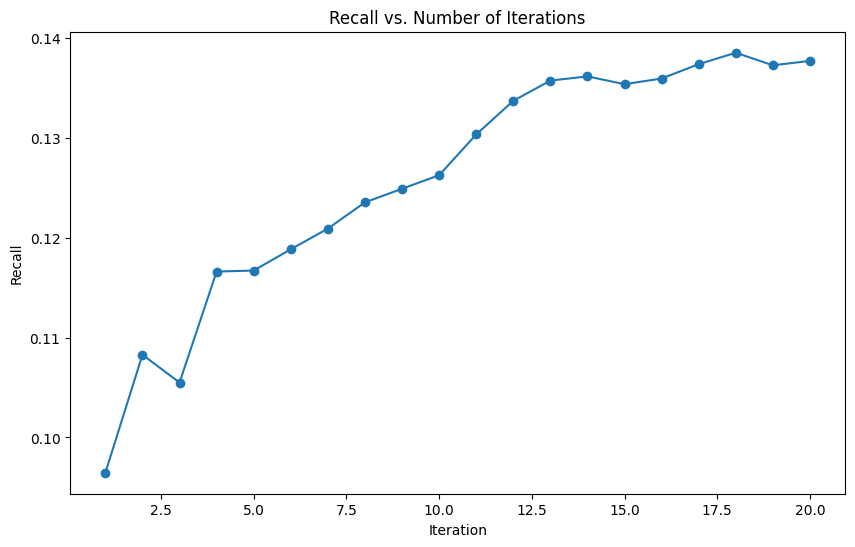

In [12]:
plot_recall_vs_iterations(recalls)


In [91]:
def plot_clusters_only(cluster_assignments, X, num_clusters, title='Clustering'):
    # Perform PCA to reduce dimensionality to 2D for plotting
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    # Ensure cluster_assignments is an array
    cluster_assignments = np.array(cluster_assignments).flatten()

    # Create a color map for the number of clusters
    cmap = plt.get_cmap('tab20', num_clusters)

    plt.figure(figsize=(10, 6))

    # Plot each cluster with a different color
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_assignments, cmap=cmap, s=5, alpha=0.6)
    plt.colorbar(scatter, ticks=range(num_clusters), label='Cluster')
    plt.title(title)
    plt.show()


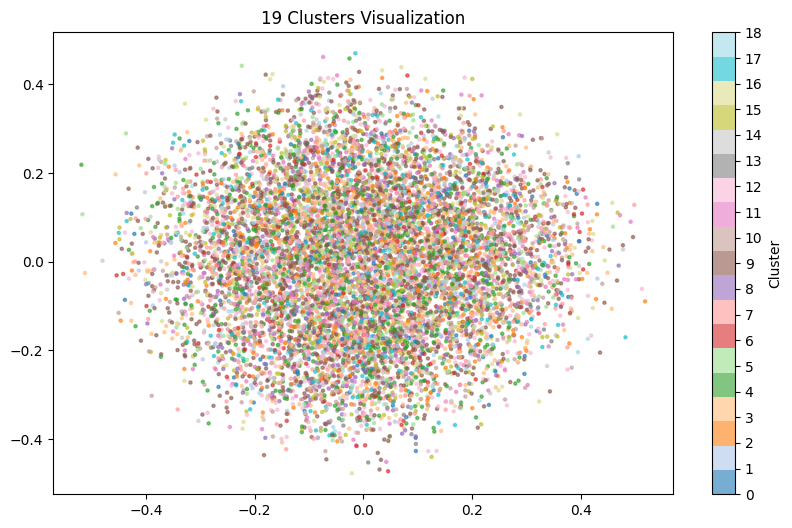

In [96]:
if len(final_cluster_assignments) < len(X_train_full_normalized):
    X_aligned = X_train_full_normalized[:len(final_cluster_assignments)]
else:
    X_aligned = X_train_full_normalized

plot_clusters_only(final_cluster_assignments, X_aligned, num_clusters=19, title='19 Clusters Visualization')
